In [1]:
import numpy as np
# import optbinning
import pandas as pd
import sklearn.linear_model
import sklearn.preprocessing
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# from yc_younipy.metrics.model.roc_auc import gini_computation as gini
from sklearn.metrics import make_scorer, roc_auc_score
import optbinning
import matplotlib.pyplot as plt
import pathlib

from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.utils.saving import save_detector, load_detector

(CVXPY) Jan 05 08:40:45 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:45 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


# ETL

In [2]:
df = pd.read_csv("datatraining.txt", index_col=0)
df.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [3]:
df.isna().sum()

date             0
Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [4]:
df.dtypes

date              object
Temperature      float64
Humidity         float64
Light            float64
CO2              float64
HumidityRatio    float64
Occupancy          int64
dtype: object

In [5]:
df = df.sort_values(by=['date'])
df

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.500000,0.004757,1
...,...,...,...,...,...,...,...
8139,2015-02-10 09:29:00,21.05,36.0975,433.0,787.250000,0.005579,1
8140,2015-02-10 09:29:59,21.05,35.9950,433.0,789.500000,0.005563,1
8141,2015-02-10 09:30:59,21.10,36.0950,433.0,798.500000,0.005596,1
8142,2015-02-10 09:32:00,21.10,36.2600,433.0,820.333333,0.005621,1


In [6]:
print(df["date"].min())
print(df["date"].max())

2015-02-04 17:51:00
2015-02-10 09:33:00


In [7]:
features_covariate = ["Temperature",  "Humidity", "Light", "CO2", "HumidityRatio"]
X_train = df[features_covariate].copy()
y_train = df["Occupancy"].copy()

# Cross validation

In [8]:
def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == "ZMQInteractiveShell":
            return True  # Jupyter notebook or qtconsole
        elif shell == "TerminalInteractiveShell":
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False  # Probably standard Python interpreter


def compute_global_figures(X, target):
    df = (
        pd.Series(
            {
                "contracts": int(X["contract_reference"].count()),
                "contracts with target": int(X[target].count()),
                "defaults": int(X[target].sum()),
                "default rate": X[target].mean(),
                "beg": X["application_date"].min().date(),
                "last with target": X.loc[~X[target].isna(), "application_date"].max().date(),
                "end": X["application_date"].max().date(),
            }
        )
        .to_frame()
        .T
    )
    return df.style.format(
        {
            "default rate": "{:.2%}",
        },
        thousands=",",
    )

def pprint_dataframe(X, **kwargs):
    if is_notebook():
        from IPython.display import display

        display(X)
    else:
        kwargs.setdefault("showindex", "never")
        kwargs.setdefault("headers", "keys")
        kwargs.setdefault("tablefmt", "psql")
        kwargs.setdefault("floatfmt", ".4f")
        kwargs.setdefault("intfmt", ",")
        if isinstance(X, pd.io.formats.style.Styler):
            X = X.data
        print(tabulate.tabulate(X, **kwargs))

In [9]:
# local functions
def print_cross_validation(cv):
    """
    prints cross-validation results in a dataframe, e.g. gini, brier, std...
    @param cv: cross-validation object
    @return: dataframe with relevant statistics
    """
    sort_key = f"mean_test_{cv.refit}" if isinstance(cv.refit, str) else "mean_test_score"

    df = (
        pd.json_normalize(cv.cv_results_["params"])
        .assign(
            **{
                f"{prefix}_{step}_{metric}": cv.cv_results_[f"{prefix}_{step}_{metric}"]
                for metric in cv.scoring
                for prefix in ("mean", "std")
                for step in ("test",)
            }
        )
        .sort_values(sort_key, ascending=False)
    )
    df["clf"] = df["clf"].apply(lambda clf: clf.version)
    try:
        df = df[~df["mean_test_auc"].isna()]
    except KeyError:
        df = df

    try:

        def apply_style(df):
            return (
                df.style.background_gradient(
                    axis=1,
                    vmin=0,
                    vmax=df["mean_test_roc_auc"].max(),
                    subset="mean_test_roc_auc",
                    # cmap=YC_PINKS,
                )
                .format(precision=4)
                .hide(axis="index")
            )

        pprint_dataframe(apply_style(df))
        pprint_dataframe(
            apply_style(
                df.groupby("clf", as_index=False).first().sort_values(f"mean_test_{selection_metric}", ascending=False)
            )
        )
    except KeyError:
        df = df
    return df

In [10]:
class FlattenTransformer(sklearn.base.TransformerMixin, sklearn.base.BaseEstimator):
    """
    This class is used in order to create the features used for model candidate v3
    - fit method is a dummy method.
    - transform is used for the features creation.
    """

    def __init__(self):
        self._is_fitted = False

    def fit(self, X, y=None):
        self._is_fitted = True
        return self

    def set_output(self, *, transform=None):
        self._is_set_output = True
        return self

    def transform(self, X_input, y=None):
        # Return the transformed DataFrame
        return X


In [11]:
clf_v3_optb_logit = sklearn.pipeline.Pipeline(
    steps=[
        (
            "encoder",
            optbinning.BinningProcess(
                variable_names=features_covariate,
                # categorical_variables=v3_cat_features,
                max_pvalue=0.05,
            ),
        ),
        # ("removing_features_with_low_variance", VarianceThreshold(threshold=0.01)),
        ("scaler", sklearn.preprocessing.StandardScaler()),
        # ('feature_selection', feature_selector),
        (
            "logistic",
            sklearn.linear_model.LogisticRegression(random_state=0),
        ),
    ]
)
clf_v3_optb_logit.version = "v3.1-optb-logit"

clf_rf = sklearn.pipeline.Pipeline(
    steps=[
        # (
        #     "encoder",
        #     optbinning.BinningProcess(
        #         variable_names=features_covariate,
        #         # categorical_variables=v3_cat_features,
        #         max_pvalue=0.05,
        #     ),
        # ),
        # # ("removing_features_with_low_variance", VarianceThreshold(threshold=0.01)),
        # ("scaler", sklearn.preprocessing.StandardScaler()),
        # # ('feature_selection', feature_selector),
        (
            "forest",
            RandomForestClassifier(random_state=0),
        ),
    ]
)
clf_rf.version = "rf_classifier"


# grid of hyperparameters to be tested
grid = [
    {
        "clf": [clf_v3_optb_logit],
        # "clf__encoder__binning_fit_params": { [None, 0.01, 0.02, 0.03, 0.04, 0.05]},
        # "clf__logistic__C": [0.01, 0.03, 0.1, 0.3, 1],
        "clf__logistic__C": np.logspace(-3, 1, 10),  # np.linspace(0.001, 1, 10), # np.logspace(-3, 1, 5),
        "clf__logistic__solver": ["saga"],
        "clf__logistic__penalty": ["l1", "l2"],  # "elasticnet"],
        # "clf__logistic__l1_ratio": [0.0, 0.01, 0.1, 0.2, 0.5, 0.8, 1.0],
        "clf__logistic__max_iter": [5000],
    },
    {
        "clf": [clf_rf],
        "clf__forest__n_estimators": [50, 100, 200],  # Add RandomForest hyperparameters
        "clf__forest__max_depth": [None, 10, 20],
        "clf__forest__min_samples_split": [2, 5, 10],
        "clf__forest__min_samples_leaf": [1, 2, 4],
    },
]

In [12]:
# # Define the AUC scorer
# def auc(y_true, y_pred_prob):
#     return roc_auc_score(y_true, y_pred_prob[:, 1])

# Assuming X_train and y_train are your training data
# clf_v3_optb_logit = RandomForestClassifier()  # Replace with your actual classifier
# grid = {'clf__param_name': [param_values]}  # Replace with your actual hyperparameter grid

# Cross validation object definition and fit
selection_metric = "roc_auc"
cv = sklearn.model_selection.GridSearchCV(
    estimator=sklearn.pipeline.Pipeline(steps=[("clf", clf_v3_optb_logit)]),
    param_grid=grid,
    scoring={
        "neg_log_loss": "neg_log_loss",
        "roc_auc": "roc_auc",
        "brier": "neg_brier_score",
    },
    #cv=sklearn.model_selection.TimeSeriesSplit(n_splits=5),
    cv=sklearn.model_selection.StratifiedKFold(n_splits=5),
    verbose=1,
    refit=selection_metric,
    n_jobs=12,
    return_train_score=True,
)

cv.fit(X_train, y_train)

Fitting 5 folds for each of 101 candidates, totalling 505 fits
(CVXPY) Jan 05 08:40:57 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:57 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:57 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:57 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable s

/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/optbinning/binning/binning.py:1086: RuntimeWarning: invalid value encountered in cast
  n_nonevent = np.empty(n_bins).astype(np.int64)
/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/optbinning/binning/binning.py:1087: RuntimeWarning: invalid value encountered in cast
  n_event = np.empty(n_bins).astype(np.int64)
/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/optbinning/binning/binning.py:1086: RuntimeWarning: invalid value encountered in cast
  n_nonevent = np.empty(n_bins).astype(np.int64)
/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/optbinning/binning/binning.py:1087: RuntimeWarning: invalid value encountered in cast
  n_event = np.empty(n_bins).astype(np.int64)


(CVXPY) Jan 05 08:40:58 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:58 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:58 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:58 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:40:58 PM: Encounte

/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/optbinning/binning/binning.py:1086: RuntimeWarning: invalid value encountered in cast
  n_nonevent = np.empty(n_bins).astype(np.int64)
/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/optbinning/binning/binning.py:1087: RuntimeWarning: invalid value encountered in cast
  n_event = np.empty(n_bins).astype(np.int64)


(CVXPY) Jan 05 08:41:07 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:41:07 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:41:08 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:41:08 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Jan 05 08:41:08 PM: Encounte

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('clf',
                                        Pipeline(steps=[('encoder',
                                                         BinningProcess(max_pvalue=0.05,
                                                                        variable_names=['Temperature',
                                                                                        'Humidity',
                                                                                        'Light',
                                                                                        'CO2',
                                                                                        'HumidityRatio'])),
                                                        ('scaler',
                                                         StandardScaler()),
                                                        ('logistic',
                                                         LogisticRegression(random_state=0))]))]),
             n_jobs=12,
             param_grid=[{'clf'...
                         {'clf': [Pipeline(steps=[('forest',
                                                   RandomForestClassifier(random_state=0))])],
                          'clf__forest__max_depth': [None, 10, 20],
                          'clf__forest__min_samples_leaf': [1, 2, 4],
                          'clf__forest__min_samples_split': [2, 5, 10],
                          'clf__forest__n_estimators': [50, 100, 200]}],
             refit='roc_auc', return_train_score=True,
             scoring={'brier': 'neg_brier_score',
                      'neg_log_loss': 'neg_log_loss', 'roc_auc': 'roc_auc'},
             verbose=1)

clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
v3.1-optb-logit,0.0077,5000.0000,l2,saga,nan,nan,nan,nan,-0.0909,0.0461,0.9918,0.0148,-0.0201,0.0139
v3.1-optb-logit,0.0028,5000.0000,l2,saga,nan,nan,nan,nan,-0.1214,0.0427,0.9917,0.0148,-0.0260,0.0126
v3.1-optb-logit,0.0215,5000.0000,l2,saga,nan,nan,nan,nan,-0.0767,0.0513,0.9917,0.0147,-0.0175,0.0142
v3.1-optb-logit,0.0599,5000.0000,l2,saga,nan,nan,nan,nan,-0.0700,0.0570,0.9917,0.0147,-0.0152,0.0134
v3.1-optb-logit,0.1668,5000.0000,l2,saga,nan,nan,nan,nan,-0.0683,0.0638,0.9916,0.0149,-0.0139,0.0133
v3.1-optb-logit,0.0010,5000.0000,l2,saga,nan,nan,nan,nan,-0.1776,0.0405,0.9916,0.0148,-0.0408,0.0115
v3.1-optb-logit,0.1668,5000.0000,l1,saga,nan,nan,nan,nan,-0.0701,0.0656,0.9916,0.0146,-0.0144,0.0134
v3.1-optb-logit,0.4642,5000.0000,l2,saga,nan,nan,nan,nan,-0.0726,0.0706,0.9915,0.0150,-0.0150,0.0135
v3.1-optb-logit,0.0599,5000.0000,l1,saga,nan,nan,nan,nan,-0.0707,0.0606,0.9915,0.0145,-0.0159,0.0139
v3.1-optb-logit,1.2915,5000.0000,l2,saga,nan,nan,nan,nan,-0.0795,0.0776,0.9913,0.0152,-0.0164,0.0140


clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
v3.1-optb-logit,0.0077,5000.0000,l2,saga,nan,nan,nan,nan,-0.0909,0.0461,0.9918,0.0148,-0.0201,0.0139
rf_classifier,nan,nan,None,None,10.0000,4.0000,10.0000,200.0000,-0.2597,0.2843,0.9893,0.0103,-0.0281,0.0186


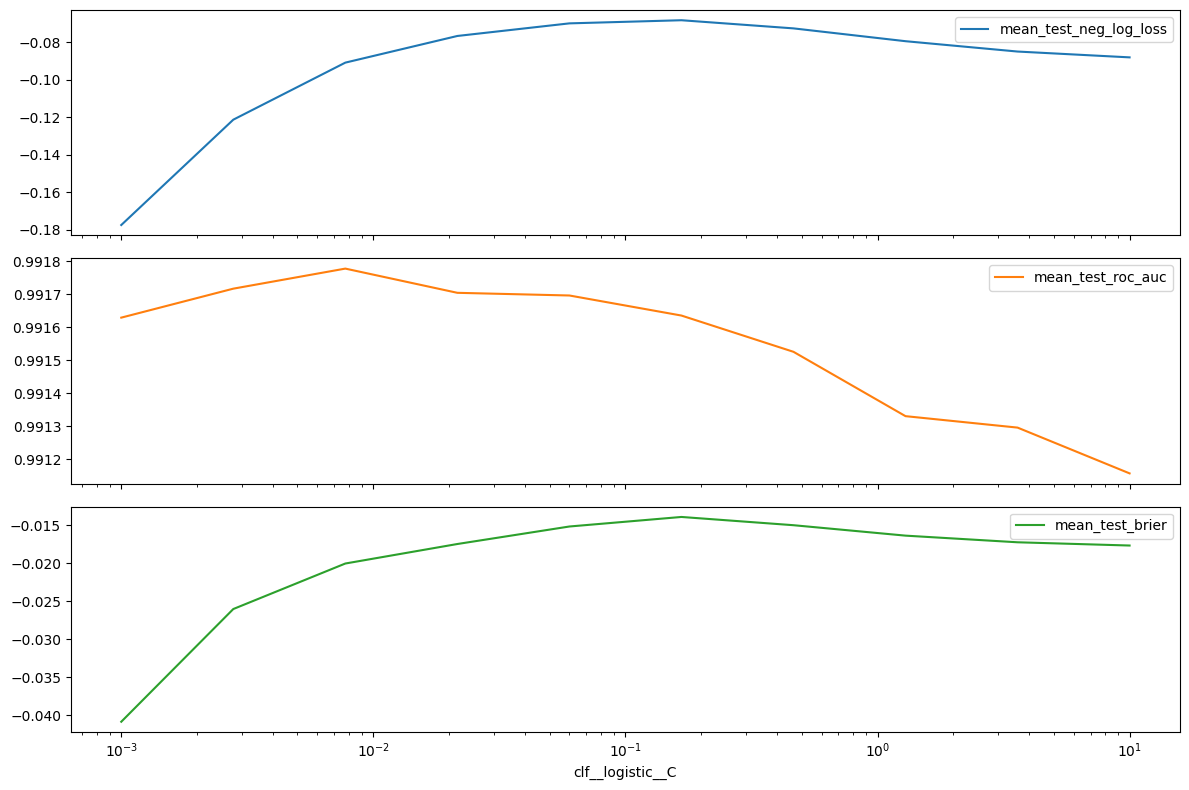

<Figure size 640x480 with 0 Axes>

In [13]:
######################################
# cross-validation results and plots #
######################################
dvc_plots = pathlib.Path("plots/")
dvc_plots.mkdir(exist_ok=True)
df_cv = print_cross_validation(cv)
axes = (
    df_cv.query("clf__logistic__penalty=='l2'")
    .query("clf=='v3.1-optb-logit'")
    .groupby("clf__logistic__C")[[f"mean_test_{scoring}" for scoring in cv.scoring]]
    .mean()
    .plot(subplots=True, logx=True, figsize=(12, 8))
)
plt.tight_layout()
if is_notebook():
    plt.show()
plt.savefig(dvc_plots / "C.png")

# cross-validation best models candidates
# Create a boolean mask indicating the duplicate rows in the 'clf' column
mask = df_cv["clf"].duplicated(keep="first")
# Invert the boolean mask to select the non-duplicate rows
df_best_models = df_cv[~mask].copy()
df_best_models.to_csv(("./data/best_models.csv"))


In [18]:
cv.best_estimator_#.predict_proba

Pipeline(steps=[('clf',
                 Pipeline(steps=[('encoder',
                                  BinningProcess(max_pvalue=0.05,
                                                 variable_names=['Temperature',
                                                                 'Humidity',
                                                                 'Light', 'CO2',
                                                                 'HumidityRatio'])),
                                 ('scaler', StandardScaler()),
                                 ('logistic',
                                  LogisticRegression(C=0.007742636826811269,
                                                     max_iter=5000,
                                                     random_state=0,
                                                     solver='saga'))]))])

In [20]:
cv.best_estimator_.predict(X_train)[0]

1

In [14]:
# cv.cv_results_

In [15]:
df_best_models

,clf,clf__logistic__C,clf__logistic__max_iter,clf__logistic__penalty,clf__logistic__solver,clf__forest__max_depth,clf__forest__min_samples_leaf,clf__forest__min_samples_split,clf__forest__n_estimators,mean_test_neg_log_loss,std_test_neg_log_loss,mean_test_roc_auc,std_test_roc_auc,mean_test_brier,std_test_brier
5,v3.1-optb-logit,0.007743,5000.0,l2,saga,NaN,NaN,NaN,NaN,-0.090914,0.046115,0.991777,0.014767,-0.020051,0.013858
73,rf_classifier,NaN,NaN,NaN,NaN,10.0,4.0,10.0,200.0,-0.259740,0.284310,0.989272,0.010252,-0.028052,0.018578


In [22]:
from joblib import load

# Load model 
filename = 'classification_model.joblib'
model = load(filename)
# Open data
df = pd.read_csv("datatraining.txt", index_col=0)
# sort dataframe by date
df = df.sort_values(by=['date'])
# define covariate and target
features_covariate = ["Temperature",  "Humidity", "Light", "CO2", "HumidityRatio"]
X_train = df[features_covariate].copy()

In [51]:
prediction = model.predict(X_train)
res = ['Empty' if pred == 0 else 'Occupied' for pred in prediction]
model_prob = model.predict_proba(X_train)[1]

In [56]:
X_input = pd.read_csv("datatraining.txt", index_col=0).sort_values(by=['date']).to_dict(orient="records")

In [78]:
# 1. Library imports
import pandas as pd 
from sklearn.ensemble import RandomForestClassifier
from pydantic import BaseModel
import joblib
# import uvicorn
# from fastapi import FastAPI


# 2. Class which describes a single flower measurements
class RoomDetection(BaseModel):
    Temperature: float 
    Humidity: float 
    Light: float 
    CO2: float
    HumidityRatio: float


# 3. Class for training the model and making predictions
class Model:
    # 6. Class constructor, loads the dataset and loads the model
    #    if exists. If not, calls the _train_model method and 
    #    saves the model
    def __init__(self):
        self.df = pd.read_csv('datatraining.txt')[["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"]]
        self.model_fname_ = 'classification_model.joblib'
        self.model = joblib.load(self.model_fname_)


    # # 5. Make a prediction based on the user-entered data
    # #    Returns the predicted species with its respective probability
    # def predict_presence(self, temperature, humidity, light, cotwo, humidityratio):
    #     data_in = [[temperature, humidity, light, cotwo, humidityratio]]
    #     prediction = self.model.predict(data_in)
    #     res = ['Empty' if pred == 0 else 'Occupied' for pred in prediction]
    #     probability = self.model.predict_proba(data_in).max()
    #     return prediction[0], probability

    def predict_presence(self, temperature, humidity, light, cotwo, humidityratio):
        data_in = pd.DataFrame([[temperature, humidity, light, cotwo, humidityratio]], columns=self.df.columns)
        prediction = self.model.predict(data_in)
        res = ['Empty' if pred == 0 else 'Occupied' for pred in prediction]
        probability = self.model.predict_proba(data_in)[:, 1]#.max()
        return res[0], probability


# 2. Create app and model objects
# app = FastAPI()
model = Model()

In [79]:
# RoomDetection

In [80]:
# Assuming you have values for the RoomDetection fields
room_data = {
    "Temperature": 25.0,
    "Humidity": 50.0,
    "Light": 300.0,
    "CO2": 400.0,
    "HumidityRatio": 0.0025
}

# Create an instance of the RoomDetection class
room_instance = RoomDetection(**room_data)

# Call the dict method on the instance
data = room_instance.dict()

# Now you can proceed with the prediction
prediction, probability = model.predict_presence(
    data["Temperature"], data["Humidity"], data["Light"], data["CO2"], data["HumidityRatio"]
)

result = {
    'prediction': prediction,
    'probability': probability
}

In [81]:
result

{'prediction': 'Empty', 'probability': array([0.07217266])}

In [76]:
# data = RoomDetection.dict()
# prediction, probability = model.predict_presence(
#     data["Temperature"], data["Humidity"], data["Light"], data["CO2"], data["HumidityRatio"]
# )
# {
#     'prediction': prediction,
#     'probability': probability
# }

In [53]:
model_prob

array([0.89044126, 0.89044126, 0.89044126, ..., 0.94094637, 0.94094637,
       0.94094637])

In [25]:
model_prob

0.8904412631968285

# Drift check

In [20]:
X_ref = df[features_covariate].copy()
cd = TabularDrift(p_val=.05, x_ref=X_ref.to_numpy(copy=True))

/home/adelchiasta/venv/venv_notebook/lib64/python3.9/site-packages/alibi_detect/cd/tabular.py:113: UserWarning: No `categories_per_feature` dict provided so all features are assumed to be numerical. `KSDrift` will be applied to all features.
  warnings.warn('No `categories_per_feature` dict provided so all features are assumed to be numerical. '


In [22]:
preds = cd.predict(X_ref.to_numpy(copy=True))
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? No!


In [23]:
!ls

attribute_information.txt  data		  datatest.txt	    old_code
classifier.ipynb	   datatest2.txt  datatraining.txt  plots


In [27]:
df2 = pd.read_csv("datatest.txt", index_col=0)
preds = cd.predict(df2[features_covariate].to_numpy(copy=True))
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? Yes!


In [29]:
df_merged = pd.concat([df[features_covariate],df2[features_covariate]]).copy()

preds = cd.predict(df_merged.to_numpy(copy=True))
labels = ['No!', 'Yes!']
print('Drift? {}'.format(labels[preds['data']['is_drift']]))

Drift? Yes!
